# M3_AI1: Consulta de la Eurostat
#### Autor: Leandro Gutierrez
#### Este documento intenta dar respuesta a la actividad individual 1 propuesta en el Modulo **Gestión de Datos y Datos Digitales** del **Master en Big Data y Ciencia de Datos**. En él se describirán cada uno de los enunciados postulados y los resultados obtenidos a través del uso de Python y Jupyter Notebook.
#### Julio 5, 2024

## Enunciado
A partir del generador de consultas de Eurostat construye una consulta a la API de Eurostat para obtener datos del nivel de satisfacción (código del dataset: ilc_pw01b) en Europa.

El colectivo objetivo del estudio es:
1. Nivel de educación (isced11): Tertiary education ED5-8
2. Indicador (life_sat):   JOB
3. Género (sex): T – Total
4. Edad (age): Y25-34 – From 25 to 34 years

Los datos que se piden son:
1. Crea una variable string con la url de la llamada al api de Eurostat para obtener los datos del colectivo objetivo del estudio. Ejemplo: urlEUROSTAT = "http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/XXX...... "
2. Crea un diccionario con el objeto JSON que se obtiene al realizar la petición a la API de la consulta del punto anterior. Imprime por pantalla el elemento "dimension" del diccionario creado.
   - Puedes utilizar la función urlopen() de la librería urllib.request.
3. Descarga los datos de Satisfacción en Europa (código del dataset: ilc_pw01b) en formato pandas a partir de la función get_data_df() de librería eurostat.
   - Para instalar la librería Eurostat ejecuta en colab: !pip install eurostat
4. Filtra el conjunto de datos solicitados en el punto 1 directamente en este Data Frame y presenta las 6 primeras filas.
5. Construye un gráfico donde se presente el nivel de satisfacción en cada país del colectivo objetivo del estudio en el año 2018.
¿En qué país están más satisfechos con el trabajo en 2018? ¿En qué país están menos satisfechos?

In [1]:
# instalamos dependencias para entorno Colab
if 'google.colab' in str(get_ipython()):
    !python -m pip install eurostat

## Solución

### Diccionario de datos

<table>
<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th><th><b>Key</b></th></tr>
<tr>
    <td>frec</td>
    <td>Frecuencia de toma de observaciones.</td>
    <td></td>
</tr>
<tr>
    <td>life_sat</td>
    <td>Ambito de satisfacción en la vida.</td>
    <td>FIN, ACCOM, JOB, COM, TIME, REC_GA, LIVENV, PER_RELS, MEANLIFE</td>
</tr>
<tr>
    <td>statinfo</td>
    <td>Medida estasdistica utilizada.</td>
    <td>AVG</td>
</tr>
<tr>
    <td>isced11</td>
    <td>Nivel educacional logrado. </td>
    <td></td>
</tr>
<tr>
    <td>sex</td>
    <td>Sexo.</td>
    <td>T, M, F</td>
</tr>
<tr>
    <td>age</td>
    <td>Clase etaria de la muestra.</td>
    <td>Y16-19, Y16-24, Y16-29, Y_GE16, Y20-24, Y25-29, Y25-34, Y25-64, Y35-49, Y50-64, Y65-74, Y_GE65, Y_GE75</td>
</tr>
<tr>
    <td>geo</td>
    <td>Monto de Ventas durante el año calendario, expresado en millones de Euros</td>
    <td>EU27_2020, BE, BG, ..., ES, ..., UK, .., TR, XK</td>
</tr>
<tr>
    <td>unit</td>
    <td>Unidad de medición</td>
    <td>RTG</td>
</tr>
<tr>
    <td>2013</td>
    <td>Medición para el periodo 2023</td>
    <td></td>
</tr>
<tr>
    <td>2018</td>
    <td>Medición para el periodo 2018</td>
    <td></td>
</tr>
<tr>
    <td>2022</td>
    <td>Medición para el periodo 2022</td>
    <td></td>
</tr>
</tbody>
</table>


### Análisis de los tipos de variables

1. frec: identifica la frecuencia de la toma de la observación. Es una variable alfanumérica, nos sirve para agrupar y clasificar, no presenta orden o jerarquia. Solo toma el valor 'A' en el dataset seleccionado. Variable cualitativa nominal.
2. life_sat: identifica ámbito donde se determinará el nivel de satisfacción del grupo encuestado. Es una variable alfanumérica, nos sirve para agrupar y clasificar, no presenta orden o jerarquia. Variable cualitativa nominal
3. statinfo: identifica el estadístico utilizado para el cálculo del nivel de satisfacción. AVG (promedio) es el único estadístico disponible. Variable cualitativa nominal.
4. isced11: identifica el nivel de educación logrado. Variable alfanumerica, que nos sirve para agrupar y clasificar, presenta indicios de orden y jerarquía. Toma tres valores posibles: ED0-2, ED3-4, ED5-8. Variable cualitativa ordinal.
5. sex: identifica sexo del grupo encuestado. Sirve para agrupar y clasificar, no presenta orden o jerarquía. Variable cualitativa nominal.
6. age: identifica rango etario del grupo. Variable alfanumérica, nos sirve para agrupar y clasificar, presenta indicios de orden pero con superposición de rangos. Variable cuantitativa ordinal.
7. unit: indetifica unidad de medida. RTG (rating) es el único valor disponible, indica que la medición toma valores entre 0 y 10. Variable cualitativa nominal.
8. geo: identifica lugar de procedencia del grupo encuestado. Se utiliza el código de representación ISO 3166-1 alpha-2 con dos caracteres alfabéticos. Toma 28 valores posibles, 27 paises y la opción "todos", representando la UE completa. Variable cualitativa nominal.
9. 2013 - 2018 - 2022: Variables que representan la toma de la medicición para distintos años. Su valor dependerá del estadístico (statinfo) y de la unidad (unit) seleccionados. Éste dataset solo presenta medidas AVG de la unidad RTG, es decir cada grupo poblacional (representado por una fila) tendrá expresado en estas variables el nivel de satisfacción en cada ambito de su vida, a través de la media de la calificación que cada integrante del grupo indicó. Variables cuantitativas continuas.

### Obtención de los datos con **requests** y visualización de *dimension*

In [2]:
import requests
import json
import eurostat

# definición de la url de los datos en fn de lo requerido
url = 'https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/ilc_pw01b?format=JSON&life_sat=JOB&isced11=ED5-8&sex=T&age=Y25-34&lang=en'

# realizamos el request
response = requests.get(url)

# creacion del dict
resp_dict = json.loads(response.content)

print(json.dumps(resp_dict['dimension'], indent=4))

{
    "freq": {
        "label": "Time frequency",
        "category": {
            "index": {
                "A": 0
            },
            "label": {
                "A": "Annual"
            }
        }
    },
    "life_sat": {
        "label": "Life satisfaction",
        "category": {
            "index": {
                "JOB": 0
            },
            "label": {
                "JOB": "Job"
            }
        }
    },
    "statinfo": {
        "label": "Statistical information",
        "category": {
            "index": {
                "AVG": 0
            },
            "label": {
                "AVG": "Average"
            }
        }
    },
    "isced11": {
        "label": "International Standard Classification of Education (ISCED 2011)",
        "category": {
            "index": {
                "ED5-8": 0
            },
            "label": {
                "ED5-8": "Tertiary education (levels 5-8)"
            }
        }
    },
    "sex": {
        "l

### Obtención de los datos a través de la lib **eurostat**

In [3]:
# obtenemos el dataframe completo con lib eurostat
df_org = eurostat.get_data_df(code='ilc_pw01b')
df_org.head(6)

,freq,life_sat,statinfo,isced11,sex,age,unit,geo\TIME_PERIOD,2013,2018,2022
0,A,ACCOM,AVG,ED0-2,F,Y16-19,RTG,AT,8.7,NaN,NaN
1,A,ACCOM,AVG,ED0-2,F,Y16-19,RTG,BE,8.0,NaN,NaN
2,A,ACCOM,AVG,ED0-2,F,Y16-19,RTG,BG,6.0,NaN,NaN
3,A,ACCOM,AVG,ED0-2,F,Y16-19,RTG,CH,8.5,NaN,NaN
4,A,ACCOM,AVG,ED0-2,F,Y16-19,RTG,CY,8.3,NaN,NaN
5,A,ACCOM,AVG,ED0-2,F,Y16-19,RTG,CZ,6.8,NaN,NaN


Podemos observar la forma y valores de los primeros 6 registros del dataset completo.

In [4]:
# filtramos y copiamos el dataframe para no editar el original
df_aux = df_org[(df_org['isced11'] == 'ED5-8') &
                (df_org['life_sat'] == 'JOB') &
                (df_org['sex'] == 'T') &
                (df_org['age'] == 'Y25-34')].copy()

# renombramos columna 'geo\TIME_PERIOD' para facilitar manipulación
df_aux = df_aux.rename(columns={'geo\\TIME_PERIOD': 'geo'})

df_aux.head(6)

,freq,life_sat,statinfo,isced11,sex,age,unit,geo,2013,2018,2022
21302,A,JOB,AVG,ED5-8,T,Y25-34,RTG,AL,NaN,6.5,NaN
21303,A,JOB,AVG,ED5-8,T,Y25-34,RTG,AT,8.1,8.0,NaN
21304,A,JOB,AVG,ED5-8,T,Y25-34,RTG,BE,7.4,7.6,NaN
21305,A,JOB,AVG,ED5-8,T,Y25-34,RTG,BG,6.9,7.0,NaN
21306,A,JOB,AVG,ED5-8,T,Y25-34,RTG,CH,7.6,7.5,NaN
21307,A,JOB,AVG,ED5-8,T,Y25-34,RTG,CY,7.4,7.4,NaN


Se pueden apreciar los primeros 6 registros una vez aplicado el filtro con los criterios requeridos:
1. Nivel de educación (isced11): Tertiary education ED5-8
2. Indicador (life_sat):   JOB
3. Género (sex): T – Total
4. Edad (age): Y25-34 – From 25 to 34 years

Veamos un análisis gráfico del grupo objetivo seleccionado para el año 2018:

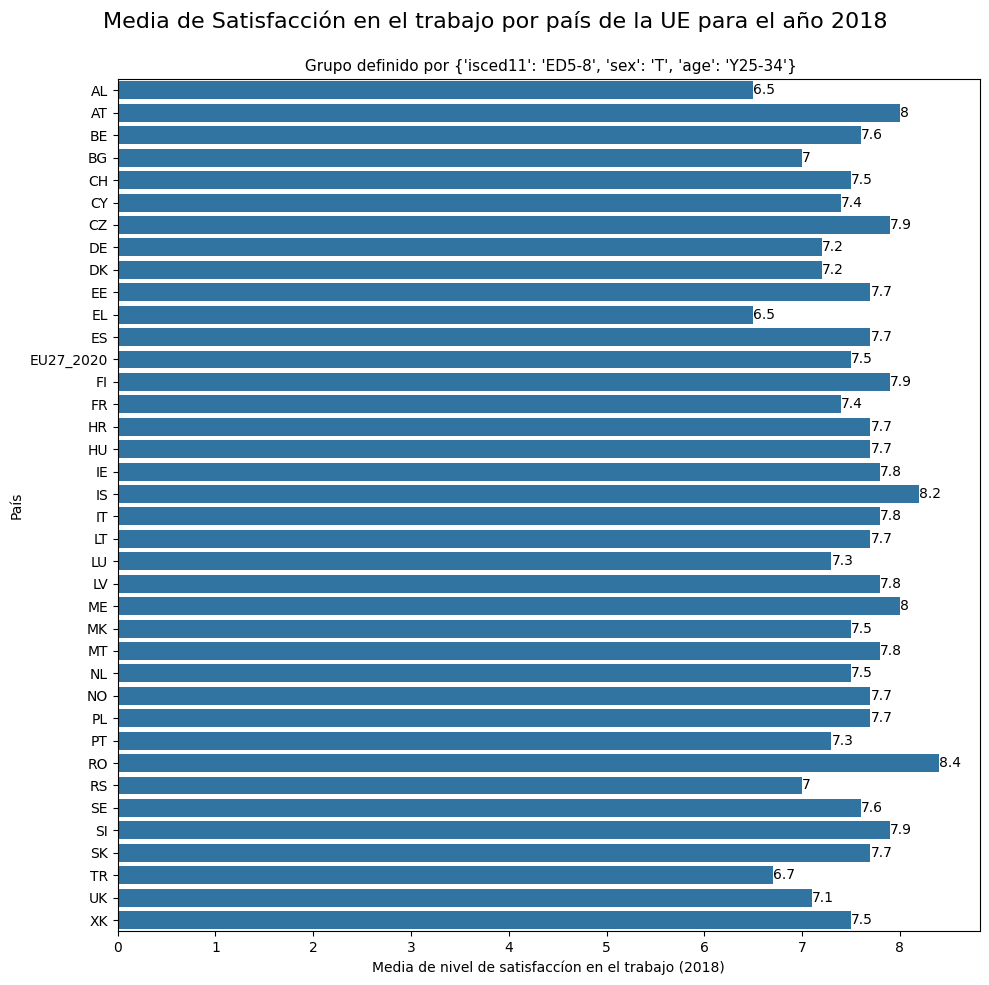

In [5]:
# importamos dependencias
import seaborn as sns
import matplotlib.pyplot as plt

# establecemos el tamaño del lienzo
plt.figure(figsize=(10, 10))  # Ancho, Alto

# creamos el barploy
bars = sns.barplot(df_aux, x="2018", y="geo")

# establecemos la etiqueta de los ejes
bars.set_ylabel("País") ## además contiene el elemento "todos" (EU27_2020)
bars.set_xlabel("Media de nivel de satisfaccíon en el trabajo (2018)")

# agregamos labels a las barras
bars.bar_label(bars.containers[0], fontsize=10);

# ajustamos titulo y subtitulo
plt.suptitle("Media de Satisfacción en el trabajo por país de la UE para el año 2018", fontsize=16)
plt.title("\n Grupo definido por {'isced11': 'ED5-8', 'sex': 'T', 'age': 'Y25-34'}", fontsize=11)
plt.tight_layout(rect=[0, 0, 1, 1])

Veamos los minimos y máximos para los valores del indicador de satisfacción en el trabajo, recordemos que estas observaciones corresponden al año 2018.

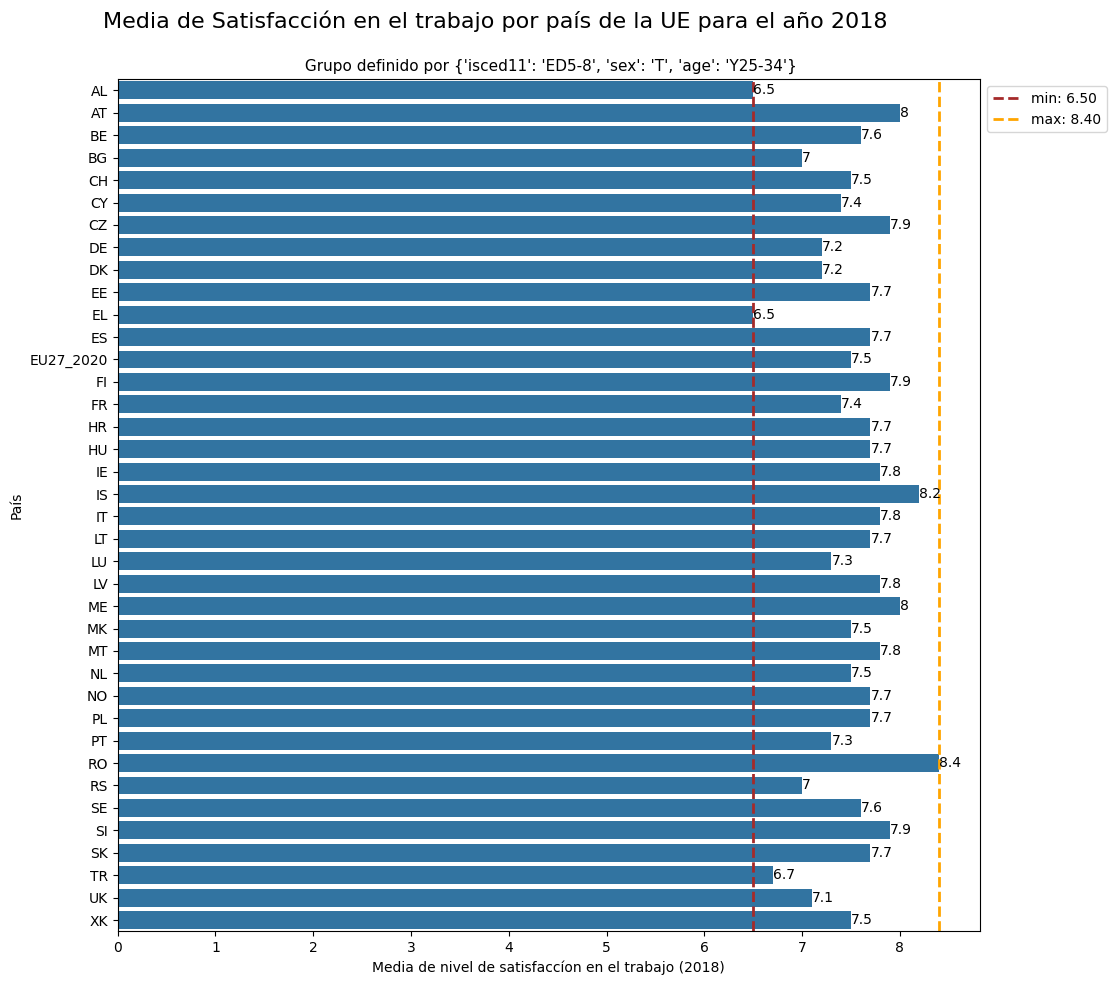

In [6]:
# establecemos el tamaño del lienzo
plt.figure(figsize=(10, 10))  # Ancho, Alto

# creamos el barploy
bars = sns.barplot(df_aux, x="2018", y="geo")

# establecemos la etiqueta de los ejes
bars.set_ylabel("País") ## además contiene el elemento "todos" (EU27_2020)
bars.set_xlabel("Media de nivel de satisfaccíon en el trabajo (2018)")

# agregamos labels a las barras
bars.bar_label(bars.containers[0], fontsize=10)

# ajustamos titulo y subtitulo
plt.suptitle("Media de Satisfacción en el trabajo por país de la UE para el año 2018", fontsize=16)
plt.title("\n Grupo definido por {'isced11': 'ED5-8', 'sex': 'T', 'age': 'Y25-34'}", fontsize=11)
plt.tight_layout(rect=[0, 0, 1, 1])

# encontramos min y max
min = df_aux['2018'].min()
max = df_aux['2018'].max()

# visualizamos los valores
plt.axvline(min, color='brown', linestyle='dashed', linewidth=2, label=f'min: {min:.2f}')
plt.axvline(max, color='orange', linestyle='dashed', linewidth=2, label=f'max: {max:.2f}')

# añadir una leyenda
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

Ahora encontraremos el país que posee el mayor valor en su media de satisfacción respecto del trabajo:

In [7]:
maximos_sat = df_aux[df_aux['2018'] == max]
maximos_sat[['geo', '2018']]

,geo,2018
21332,RO,8.4


Vemos que Rumania (RO) posee el índice satisfacción mas alto dentro de la UE durante el año 2018, con una media de 8.5 puntos sobre 10.

Del método gráfico podemos observar que el valor mínimo es tomado en dos oportunidades, encontremos analíticamente las correspondencias.

In [8]:
minimos_sat = df_aux[df_aux['2018'] == min]
minimos_sat[['geo', '2018']]

,geo,2018
21302,AL,6.5
21312,EL,6.5


Vemos que Albania (AL) y Grecia (EL) son los paises donde el grupo objetivo refirió un peor índice de satisfacción en su trabajo durante el año 2018, obteniendo ambos paises un 6.5 de media en dicho registro.


### Análisis final

Analicemos la variable 2018, la cual representa el nivel de satisfacción en el contexto y con el grupo objetivo indicado.

In [9]:
# encontramos media
media = df_aux['2018'].mean()

# encontramos media
mediana = df_aux['2018'].median()

# encontramos minimo y maximo
min = df_aux['2018'].min()
max = df_aux['2018'].max()

print(f'min: {min}')
print(f'max: {max}')

# encontramos varianza
var = df_aux['2018'].var()
print(f'var: {var}')

# encontramos desviacion standard
std = df_aux['2018'].std()
print(f'std: {std}')


min: 6.5
max: 8.4
var: 0.17590327169274536
std: 0.41940823989610093


In [10]:
# encontramos varianza
var = df_aux['2018'].var()
print(f'var: {var}')

# encontramos desviacion standard
std = df_aux['2018'].std()
print(f'std: {std}')

var: 0.17590327169274536
std: 0.41940823989610093


In [11]:
# encontramos Coeficiente de Variación de Sperman
cv = std / media
print(f'cv: {cv}')

cv: 0.05564774132699664


In [12]:
# obtenemos Q1 y Q3
q1 = df_aux['2018'].quantile(0.25)
q3 = df_aux['2018'].quantile(0.75)
print(f'q1: {q1}')
print(f'q3: {q3}')

# obtenemos rango intercuartílico
rq = q3 - q1
print(f'rq: {rq}')

q1: 7.325
q3: 7.8
rq: 0.47499999999999964


Vemos nuevamente, contamos con 38 registros, con una media de 7.53 puntps de satisfacción. Una varianza de 0.17 y una desviación estandard de 0.41 puntos de rating sobre 10. Un mínimo de 6.50 y un max de 8.40 puntos. Mientras que la mediana es de 7.65 puntos; y los cuartiles Q1 y Q3 son 7.32 y 7.80 respectivamente.

Podemos apreciar que la mediana es ligeramente mas alta que la media, lo que expresa una leve concentración hacia valores mas pequeños, los cuales llevan la media hacia abajo. Podemos obtener tambien un Coeficiente de variación de 5.56%, lo que nos permite decir que el conjunto de datos es homogeneo, es decir tienen una disperción pequeña respecto del valor medio.

También podemos obtener un rango intercuartil de 0.47 puntos sobre 10, lo que indica una variabilidad moderada y alta concentración de valores cerca de la mediana.

Así mismo vimos que el país con mejor indice de satisfacción en el trabajo durante el periodo 2018, para el grupo objetivo especificado, fué Rumania con una media de satisfacción de 8.4 puntos. Mientras que Grecia y Albania fueron los que peor se desenvolvieron en este apartado, con medias de 6.5 puntos por igual.
